In [199]:
import pandas as pd
import os
from nltk.tokenize import word_tokenize
from num2words import num2words
import nltk
import string
import unicodedata
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pickle
import math
import numpy as np
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize
import operator
from sklearn.model_selection import train_test_split
import random
from tqdm import tqdm
import copy

In [200]:
folder_name ='Assignment3_IR/20_newsgroups'
folders = ['sci.med','talk.politics.misc','rec.sport.hockey','sci.space', 'comp.graphics']

In [201]:
#uploading of data in this block and appending files and class_names to X and Y.
X=[]
Y=[]
f=[]
total_doc=0
files_path=[]
labels=[]
for folder in folders:
    for files in (os.listdir(folder_name+'/'+folder)):
        i=str(folder_name+'/'+folder+'/'+files)
        total_doc+=1
        files_path.append(i)
        labels.append(folder)
        X.append((files))
        f.append(files)
        Y.append(folder)

In [202]:
#as the name suggest here data is splitted into train and test data, user need to enter train split ratio in fraction.

def train_test_split(X,Y,split_ratio):
    length_X =len(X)
    #length_Y = len(Y)
    #length_Y = len(folders)
    files_class = int(length_X/len(folders))
    frac = int((length_X/len(folders))*(split_ratio))
    train_X =[] 
    train_Y=[]
    test_X =[]
    test_Y=[]
    #list1=list2=list3=list4=list5=[]
    ctr = 0
    #l = list(range(len(X)))
    #random.shuffle(l)
    for i in range(1,(len(folders)+1)):
        l = list(range(0+ctr,files_class+ctr))
        random.shuffle(l)
        c = 0+ctr
        for j in l:
            if c < frac + ctr:
                train_X.append(X[j])
                train_Y.append(Y[j])
            else:
                test_X.append(X[j])
                test_Y.append(Y[j])
            c+=1
            #print(c)
        ctr = files_class * i
    return train_X,test_X,train_Y,test_Y

In [203]:
#function calling 
train_X,test_X,train_Y,test_Y = train_test_split(X,Y,0.8)

In [204]:
def removeHeader(text):
    paragraphs = text.split('\n\n')
    metadata_removed_text = ""
    text_list = []
    for i in range(1 , len(paragraphs)):
        metadata_removed_text = metadata_removed_text + paragraphs[i]
    return metadata_removed_text

In [205]:
#function used for data preprocessing includes removal of stopwords,punctuations and words of length 1.
#words are converted into lowercase and num2words.
def preprocess_data(text):
    token_list=[]
    ps = nltk.PorterStemmer() 
    stop_words = set(stopwords.words('english'))
    #text = removeHeader(text)
    text = text.lower()
    text = word_tokenize(text)
    punc = string.punctuation
    tokens = [i for i in text if not i in (stop_words and punc)]
    for word in tokens:
        w=word.translate(str.maketrans('','',string.punctuation))
        if len(w)>1 and w!= '' and w not in stop_words:
            w=ps.stem(w)
            if w.isnumeric():
                w = num2words(w)
                token_list.append(w)
            else:
                token_list.append(w)
    return token_list

In [206]:
#dictionary is generated
train_X_dic = {}
class_terms={}
for i in tqdm(range(len(train_X))):
    if train_Y[i] not in train_X_dic:
        train_X_dic[train_Y[i]]={} #if class_label not present add it
    if train_Y[i] not in class_terms:
        class_terms[train_Y[i]]={} #same as above
    #reading train data
    with open(folder_name+'/'+train_Y[i]+'/'+train_X[i],'r',encoding='cp1250',errors='ignore') as file:
        prc_data=preprocess_data(file.read()) #preprocessing
        
        class_terms[train_Y[i]][train_X[i]]={} # document not present then add that doc id.
        
        for j in range(len(prc_data)):
            if prc_data[j] not in class_terms[train_Y[i]][train_X[i]]:
                class_terms[train_Y[i]][train_X[i]][prc_data[j]]=1 #if word not present add it into a dictionary with value as 1
            if prc_data[j] not in train_X_dic[train_Y[i]]:
                train_X_dic[train_Y[i]][prc_data[j]]=1 # term frequency of a word in a particular class
            else:
                train_X_dic[train_Y[i]][prc_data[j]]+=1

100%|██████████| 4000/4000 [02:12<00:00, 30.25it/s]


In [207]:
#total distinct words in an entire corpus
vocab=[]
for classes in train_X_dic:
    for terms in train_X_dic[classes]:
        vocab.append(terms)
vocab = set(vocab)
print(len(vocab))

62563


In [208]:
#idf value of a term
idf=(train_X_dic).copy()
for label in train_X_dic:
    class_idf={}
    for term in train_X_dic[label]:
        val = 0
        for l in train_X_dic:
            if term in train_X_dic[l]:
                val+=1
        #print(val)
        class_idf[term] = math.log((5/val),10)
    idf[label] = class_idf

In [209]:
#tf-idf value of a term in a particular class
tf_idf={}
for label in train_X_dic:
    tf_idf_inner={}
    for term in train_X_dic[label]:
        #print(term)
        #print(tf[label][term])
        #print(idf[label][term])
        tf_idf_inner[term] = train_X_dic[label][term]*idf[label][term]
    tf_idf[label]=tf_idf_inner

In [210]:
#sorting tfidf and choose desired number of features by entering the percentage of k in fraction and updated into a train data 
import operator
train_X_dic={}
for key in tf_idf:
    train_X_dic[key] = sorted(tf_idf[key].items(), key=operator.itemgetter(1),reverse=True)
    train_X_dic[key] = dict(train_X_dic[key][:(int)((0.7)*len(train_X_dic[key]))])  #selecting some percentage among all values of I

In [211]:
#used for generating document vector of voacb size of all documents in a particular class.
doc_vector={}
for i in tqdm(range(len(train_X))):
    if train_Y[i] not in doc_vector: 
        doc_vector[train_Y[i]]={} #class label not present add it 
    if train_X[i] not in doc_vector[train_Y[i]]: 
        doc_vector[train_Y[i]][train_X[i]]=[] #adding documents of a particular class
        for term in train_X_dic[train_Y[i]]:
            if term in class_terms[train_Y[i]][train_X[i]]: #term present in doc add tf idf else 0
                doc_vector[train_Y[i]][train_X[i]].append(tf_idf[train_Y[i]][term]) 
            else:
                doc_vector[train_Y[i]][train_X[i]].append(0)
        doc_vector[train_Y[i]][train_X[i]] = np.asarray(doc_vector[train_Y[i]][train_X[i]]) #convert it to array for faster computations

100%|██████████| 4000/4000 [00:45<00:00, 88.31it/s] 


In [196]:
def compute_distance(test_doc,classes):
    distance={}
    for doc in doc_vector[classes]: #cosine similarity formula is used taking train document vector and test document vector as input
        temp = np.dot(doc_vector[classes][doc], test_doc)   
        number = math.sqrt(np.sum(np.dot(temp, temp)))
        d1 = np.sqrt(np.sum(np.dot(test_doc,test_doc)))
        d2 = np.sqrt(np.sum(np.dot(doc_vector[classes][doc], doc_vector[classes][doc])))
        try:
            distance[doc] = number/(d1*d2) #storing result into a dictionary if not 0 
        except:
            distance[doc] = 0
    return distance

In [197]:
#dictionary for mapping every document with it's class label.
mapping_doc={}
#print(doc_vector)
for i in range(len(X)):
    mapping_doc[X[i]]=Y[i]

In [198]:
predicted_1=[] #3 lists for storing predicted values of 1nn,3nn and 5nn
predicted_3=[]
predicted_5=[]
label = []
for i in tqdm(range (len(test_X))):
    #reading test data
     with open(folder_name+'/'+test_Y[i]+'/'+test_X[i],'r',encoding='cp1250',errors='ignore') as f:
        data = preprocess_data(f.read()) #preprocessing
        dist_class={}
        for classes in folders:
            class_vector = []
            for term in train_X_dic[classes]: #generating document vector for a test document similar to train data
                #print(classes,term)
                if term not in data:
                    class_vector.append(0) #if term not peresnt appending 0 else tf-idf 
                else:
                    class_vector.append(tf_idf[classes][term])
            class_vector = np.asarray(class_vector) #for faster computation changing it to array 
            distance = compute_distance(class_vector, classes) #computing distance between train and test doc and updating in a dictionary with score.
            #print(distance)
            dist_class.update(distance)
#        l = sorted(dist_class.items(),key=lambda x:x[1], reverse = True)
#        label.append(mapping_doc[l[0][0]])
#        print(mapping_doc[l[0][0]], l[0][0])
#        print(mapping_doc[l[1][0]], l[1][0])
        max_1 = max(dist_class, key = dist_class.get) #top 5 maximum values are choosen from the dictionary which has the highest distance values.
        max1 = max_1,dist_class[max_1]
        #print(min1)
        del dist_class[max_1]
        max_2 = max(dist_class, key = dist_class.get)
        max2 = max_2,dist_class[max_2]
        #print(min2)
        del dist_class[max_2]
        max_3 = max(dist_class, key = dist_class.get)
        max3 = max_3,dist_class[max_3]
        #print(min3)
        del dist_class[max_3]
        max_4 = max(dist_class, key = dist_class.get)
        max4 = max_4,dist_class[max_4]
        #print(min4)
        del dist_class[max_4]
        max_5 = max(dist_class, key = dist_class.get)
        max5 = max_5,dist_class[max_5]
        #print(min5)
        del dist_class[max_5]
        labels = {'comp.graphics':0, 'sci.med':0, 'talk.politics.misc':0, 'rec.sport.hockey':0, 'sci.space':0}
        
        labels[mapping_doc[max_1]]+=1 #mapping documents with class label using mappin dictionary defined above
        predicted_1.append(max(labels, key = labels.get)) #getting the label with maximum value
        labels[mapping_doc[max_2]]+=1
        labels[mapping_doc[max_3]]+=1
        predicted_3.append(max(labels, key = labels.get))
        labels[mapping_doc[max_4]]+=1
        labels[mapping_doc[max_5]]+=1
        predicted_5.append(max(labels, key = labels.get))

  1%|▏         | 13/1000 [00:06<07:39,  2.15it/s]/home/surbhi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
100%|██████████| 1000/1000 [10:01<00:00,  1.66it/s]


In [170]:
#accuracy 
def accuracy_metric(test, predicted):
    correct=0
    for i in range(len(test)):
        #print(predicted[i])
        if test[i] == predicted[i]: #checking the correct predictions and adding by 1 every time if correct
            correct+=1
    return correct / float(len(test))*100

In [171]:
pred_list=[predicted_1,predicted_3,predicted_5] #making a combine list of predicted values in 1nn,3nn and 5nn

In [172]:
# appending accuraies of all the predictions
acc_list=[]
pred = []
for i in range(3):
    acc = accuracy_metric(test_Y,pred_list[i])
    acc_list.append(acc)

In [173]:
#confusion matrix
def confusion(test,predicted):
    confusion_matrix = np.zeros((len(folders),len(folders)))
    count=0
    for i in range(len(predicted)):
        predicted_index = folders.index(predicted[i])
        actual_index = folders.index(test[i])
        confusion_matrix[predicted_index][actual_index]+=1
    return confusion_matrix

In [182]:
accuracy = accuracy_metric(test_Y,predicted_5)

In [183]:
con = confusion(test_Y,predicted_5)

In [184]:
print(accuracy)

94.53333333333333


In [185]:
print(con)

[[300.   6.  23.  10.  40.]
 [  0. 294.   0.   2.   0.]
 [  0.   0. 277.   0.   0.]
 [  0.   0.   0. 287.   0.]
 [  0.   0.   0.   1. 260.]]


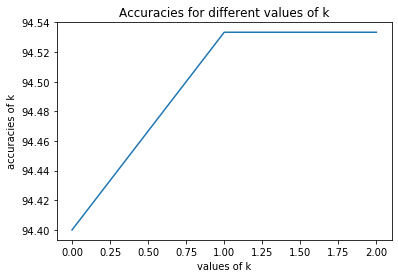

In [186]:
#comparison of accuracies between all 3 knn's
plt.plot(acc_list)
plt.title('Accuracies for different values of k')
plt.ylabel('accuracies of k')
plt.xlabel('values of k')
plt.show()